<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

### Project 4 : Indiviual Prject for GA DSI 2 Course

In this project, we will practice two major skills: collecting data by scraping a website and then building a binary predictor with Logistic Regression.

We are going to collect salary information on data science jobs in a variety of markets. Then using the location, title and summary of the job we will attempt to predict the salary of the job. For job posting sites, this would be extraordinarily useful. While most listings DO NOT come with salary information (as you will see in this exercise), being able to extrapolate or predict the expected salaries from other listings can help guide negotiations.

Normally, we could use regression for this task; however, we will convert this problem into classification and use Logistic Regression or any other suitable classifier.

- Question: Why would we want this to be a classification problem?
- Answer: While more precision may be better, there is a fair amount of natural variance in job salaries - predicting a range may be useful.

Therefore, the first part of the assignment will be focused on scraping Indeed.com. In the second, we'll focus on using listings with salary information to build a model and predict additional salaries.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, we look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### We setup a request (using `requests`) to the URL below. Using BeautifulSoup to parse the page and extract all results 

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [7]:
import requests
import bs4
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re 

In [3]:
html = requests.get(URL)
soup = BeautifulSoup(html.text, 'lxml')

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is available in a `nobr` element inside of a `td` element with `class='snip'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 

### We write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```

In [53]:
def extract_salary_from_result(result):
    salary = []
    # to find each job post
    for row in result.find_all(name='div' , attrs= {'class':'row'}):
        # to check if theres a salary, else append no salary
        try:
            row = row.find(name='span' , attrs= {'class':'salary no-wrap'})
            salary.append(row.text.strip())
        except:
            salary.append('Nosalary')
    #to return a list of salaries
    return salary

In [54]:
extract_salary_from_result(soup)

['Nosalary',
 'Nosalary',
 'Nosalary',
 'Nosalary',
 'Nosalary',
 'Nosalary',
 'Nosalary',
 'Nosalary',
 'Nosalary',
 'Nosalary',
 'Nosalary']

In [6]:
def extract_title_from_result(result):
    title = []
    try: 
        for entry in result.find_all(name='h2' , attrs= {'class':'jobtitle'}):
            title.append(entry.text.strip())
    except:
        title.append(None)
    return title

In [7]:
extract_title_from_result(soup)

['DATA SCIENCE -INTERN',
 'Data Science Intern',
 'Data Scientist - Global Investment Banking - Associate',
 "Quantitative Researcher - Internship (Bachelor's/Master's)",
 'Research Data Associate',
 'Data Scientist',
 'Data Scientist',
 'Data Scientist',
 'Part-Time Research Data Associate',
 'Data Scientist Intern, PhD, 2019']

In [8]:
def extract_company_from_result(result):
    company = []
    try: 
        for entry in result.find_all(name='span' , attrs= {'class':'company'}):
            company.append(entry.text.strip())
    except:
        company.append(None)
    return company

In [9]:
extract_company_from_result(soup)

['Foot Locker, Inc.',
 'Grubhub',
 'JP Morgan Chase',
 'Two Sigma Investments, LLC.',
 'NYU Langone',
 'Bloomberg',
 'MealPal',
 'Dow Jones',
 'NYU Langone',
 'Google']

In [10]:
def extract_location_from_result(result):
    locations = []
    try: 
        for entry in result.find_all(name='span' , attrs= {'class':'location'}):
            locations.append(entry.text)
    except:
        locations.append(None)
    return locations

In [11]:
extract_location_from_result(soup)

['New York, NY',
 'New York, NY',
 'New York, NY 10179 (Midtown area)',
 'New York, NY',
 'New York, NY',
 'New York, NY',
 'New York, NY',
 'New York, NY 10176 (Murray Hill area)',
 'New York, NY',
 'New York, NY 10011 (Chelsea area)']

Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

#### Collect results from multiple cities and starting points

In [84]:
MY_CITY = 'Jersey+City'

In [85]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 20000


In [86]:
# create a data frame
sf = pd.DataFrame(columns=["title", "location", "company", "salary", "area"])
#iterate through each city
for city in ['Chicago', 'New+York', 'San+Francisco', 'Austin', 'Seattle', 
        'Los+Angeles', MY_CITY, 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
        'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', 'Washington', 'Boston', 'Raleigh', 'San+Jose']:
    for start in range(0, max_results_per_city, 100):
        #parset he web source
        r = requests.get(url_template.format(city, start))
        html = r.text
        soup = BeautifulSoup(html ,'html.parser')
        # to check if its the last page
        if start != 0 and len(soup.find_all("span", {"class":"np"} ) )  != 2 :
            break
        else : 
            title = extract_title_from_result(soup)
            location = extract_location_from_result(soup)
            company = extract_company_from_result(soup)
            number_of_results = len(company)
            salary = extract_salary_from_result(soup)
            # to create a list of the same length as the exctracted result of the serach word
            cit = [city] * len(title)
            #zip the results in a row form
            result = [[what,where,for_who,how_much, area] for what,where,for_who,how_much, area in zip(title,location,company,salary, cit)]
            #transform to a data frame and concat it 
            results = pd.DataFrame(result,columns=["title", "location", "company", "salary", "area"])
            sf = pd.concat((sf, results),axis=0, ignore_index=True)
            
            print(start)
    print("Finished Scraping",city)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
Finished Scraping Houston
0
Finished Scraping Miami
0
100
200
300
400
500
600
700
800
900
Finished Scraping Washington
0
100
200
300
400
500
600
700
800
900
Finished Scraping Boston
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900


In [90]:
sf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17178 entries, 0 to 17177
Data columns (total 5 columns):
title       17178 non-null object
location    17178 non-null object
company     17178 non-null object
salary      17178 non-null object
area        17178 non-null object
dtypes: object(5)
memory usage: 671.1+ KB


In [58]:
# sf=sf[sf['salary'].str.contains("year")]

#### Using the functions above to parse out the 4 fields - location, title, company and salary. We have a dataframe from the results with those 4 columns.

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Finding the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, removing duplicate entries.

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [17]:
def convertsalary(salary):
    salary = str(salary).replace(",","").replace("$","") #all salaries in dollars
    salary = [int(s) for s in salary.split() if s.isdigit()]
    if len(salary)>1:
        salary = (sum(salary)/2)
    else:
        salary = (sum(salary))
    return salary

### Save your results as a CSV

In [91]:
sf.drop_duplicates(inplace=True)
sf.reset_index(inplace=True, drop=True)

In [95]:
sf.to_csv("scraped_indeed_data_luj.csv")

## QUESTION 2: Factors that distinguish job category

Using the job postings you scraped for part 1 (or potentially new job postings from a second round of scraping), identify features in the data related to job postings that can distinguish job titles from each other. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your model's performance.

#### Load in the the data of scraped salaries

In [9]:
#Since I didnt have enough time to scrape and clean enough data THEN model, I am using the provided data to start modeling
df = pd.read_csv('./all_scrapes.csv')
df.head()

,Unnamed: 0,city,company,location,salary,title
0,0,Philadelphia,Defined Clarity,"Philadelphia, PA 19123 (Poplar-Ludlow-Yorktown...",$65 - $75 an hour,Data Analyst / Data Scientist
1,1,Philadelphia,Children's Hospital of Philadelphia,"Philadelphia, PA 19146 (Point Breeze area)",No Salary,Data Scientist I
2,2,Philadelphia,Children's Hospital of Philadelphia,"Philadelphia, PA 19146 (Point Breeze area)",No Salary,Supv DBHi Data Scientist
3,3,Philadelphia,Federal Reserve Bank of Philadelphia,"Philadelphia, PA",No Salary,Real Time Data Research Analyst
4,4,Philadelphia,"Pavone Marketing Group, Inc.","Philadelphia, PA 19136 (Mayfield area)",No Salary,Data Analyst


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5375 entries, 0 to 5374
Data columns (total 6 columns):
Unnamed: 0    5375 non-null int64
city          5375 non-null object
company       5375 non-null object
location      5375 non-null object
salary        5375 non-null object
title         5375 non-null object
dtypes: int64(1), object(5)
memory usage: 252.0+ KB


In [11]:
# initial cleaning
df.drop("Unnamed: 0", axis=1, inplace=True)
df.dropna()
df.drop_duplicates(keep="first")
df.head()

,city,company,location,salary,title
0,Philadelphia,Defined Clarity,"Philadelphia, PA 19123 (Poplar-Ludlow-Yorktown...",$65 - $75 an hour,Data Analyst / Data Scientist
1,Philadelphia,Children's Hospital of Philadelphia,"Philadelphia, PA 19146 (Point Breeze area)",No Salary,Data Scientist I
2,Philadelphia,Children's Hospital of Philadelphia,"Philadelphia, PA 19146 (Point Breeze area)",No Salary,Supv DBHi Data Scientist
3,Philadelphia,Federal Reserve Bank of Philadelphia,"Philadelphia, PA",No Salary,Real Time Data Research Analyst
4,Philadelphia,"Pavone Marketing Group, Inc.","Philadelphia, PA 19136 (Mayfield area)",No Salary,Data Analyst


In [12]:
import re
import regex as re

In [13]:
#filter by salary containing year
df=df[df['salary'].str.contains("year")]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 409 entries, 70 to 5374
Data columns (total 5 columns):
city        409 non-null object
company     409 non-null object
location    409 non-null object
salary      409 non-null object
title       409 non-null object
dtypes: object(5)
memory usage: 19.2+ KB


- Noting here tht this is a very small dataset and given more time we would collect more entries

In [18]:
# avg the slary range
avr=[]
for x in df['salary']:
    avr.append(convertsalary(x))

In [19]:
df['avg_salary']=avr

In [20]:
df.drop('salary', axis=1, inplace=True)

In [21]:
df.rename(columns={'city':'metro_area'}, inplace=True)

In [22]:
df.head()

,metro_area,company,location,title,avg_salary
70,Philadelphia,Workbridge Associates,"Philadelphia, PA",Data Scientist (statistical modeling with insu...,107500.0
84,Philadelphia,Workbridge Associates,"Mount Laurel, NJ",Python Developer/Data Scientist,115000.0
89,Philadelphia,Workbridge Associates,"Wilmington, DE",Data Scientist (Statistical Modeling),97500.0
90,Philadelphia,Workbridge Associates,"Wilmington, DE","Data Scientist (Hadoop, SAS, R, Python)",95000.0
91,Philadelphia,City of Philadelphia,"Philadelphia, PA",Police Forensic Science Technician,41696.5


In [23]:
df['title'] = df['title'].str.replace('R&D', 'research development')

In [24]:
df.metro_area.value_counts()

New+York         119
San+Francisco     58
Chicago           37
Denver            26
Los+Angeles       24
Houston           21
Philadelphia      19
Austin            17
Dallas            16
Seattle           15
Atlanta           15
Boston            13
Miami             10
Portland           7
Phoenix            6
Pittsburgh         6
Name: metro_area, dtype: int64

#### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [25]:
median = df['avg_salary'].median()
print ('The median salary :',  median  )

The median salary : 114500.0


In [26]:
#create a new dummy column of whether or not the salary is above the median
high_salary = [1 if x > median else 0 for x in df['avg_salary'] ]
df['high_salary']= high_salary

In [27]:
df.head()

,metro_area,company,location,title,avg_salary,high_salary
70,Philadelphia,Workbridge Associates,"Philadelphia, PA",Data Scientist (statistical modeling with insu...,107500.0,0
84,Philadelphia,Workbridge Associates,"Mount Laurel, NJ",Python Developer/Data Scientist,115000.0,1
89,Philadelphia,Workbridge Associates,"Wilmington, DE",Data Scientist (Statistical Modeling),97500.0,0
90,Philadelphia,Workbridge Associates,"Wilmington, DE","Data Scientist (Hadoop, SAS, R, Python)",95000.0,0
91,Philadelphia,City of Philadelphia,"Philadelphia, PA",Police Forensic Science Technician,41696.5,0


In [28]:
# create new column features of certain words in the title which will help us in modeling later
df['senior']=df.title[df.title.str.contains('senior|Senior|Sr|II|Mid-Level|senior-level|Sr.')]
df['manager']=df.title[df.title.str.contains('manager|Manager|Director|Executive')]
df['analyst']=df.title[df.title.str.contains('Analyst|Analysis|Analyze')]
df['scientist']=df.title[df.title.str.contains('Scientist|Science|R&D|Research')]
df['engineer']=df.title[df.title.str.contains('Engineer|Engineering|Eng')]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 409 entries, 70 to 5374
Data columns (total 11 columns):
metro_area     409 non-null object
company        409 non-null object
location       409 non-null object
title          409 non-null object
avg_salary     409 non-null float64
high_salary    409 non-null int64
senior         105 non-null object
manager        31 non-null object
analyst        54 non-null object
scientist      211 non-null object
engineer       87 non-null object
dtypes: float64(1), int64(1), object(9)
memory usage: 38.3+ KB


In [29]:
df.head()

,metro_area,company,location,title,avg_salary,high_salary,senior,manager,analyst,scientist,engineer
70,Philadelphia,Workbridge Associates,"Philadelphia, PA",Data Scientist (statistical modeling with insu...,107500.0,0,NaN,NaN,NaN,Data Scientist (statistical modeling with insu...,NaN
84,Philadelphia,Workbridge Associates,"Mount Laurel, NJ",Python Developer/Data Scientist,115000.0,1,NaN,NaN,NaN,Python Developer/Data Scientist,NaN
89,Philadelphia,Workbridge Associates,"Wilmington, DE",Data Scientist (Statistical Modeling),97500.0,0,NaN,NaN,NaN,Data Scientist (Statistical Modeling),NaN
90,Philadelphia,Workbridge Associates,"Wilmington, DE","Data Scientist (Hadoop, SAS, R, Python)",95000.0,0,NaN,NaN,NaN,"Data Scientist (Hadoop, SAS, R, Python)",NaN
91,Philadelphia,City of Philadelphia,"Philadelphia, PA",Police Forensic Science Technician,41696.5,0,NaN,NaN,NaN,Police Forensic Science Technician,NaN


In [30]:
df.reset_index(inplace=True)

In [31]:
#fill the na for those new columns with 1 to completely dummify them 
df.manager.fillna(0 , inplace=True)
df.senior.fillna(0 , inplace=True)
df.analyst.fillna(0 , inplace=True)
df.scientist.fillna(0 , inplace=True)
df.engineer.fillna(0 , inplace=True)

In [32]:
li = ['manager','senior', 'analyst', 'scientist', 'engineer' ]
for k in li:
    for i in range(len(df)):
        if df.loc[i , k] != 0  :
            df.loc[i , k] = 1

In [33]:
#create new column for city
df['city'] = df.location.str.split(',').apply(lambda x : x[0])

In [34]:
#create new column for state
df['state'] = df.location.str.split(',').apply(lambda x : x[-1][1:3])

In [35]:
df.head()

,index,metro_area,company,location,title,avg_salary,high_salary,senior,manager,analyst,scientist,engineer,city,state
0,70,Philadelphia,Workbridge Associates,"Philadelphia, PA",Data Scientist (statistical modeling with insu...,107500.0,0,0,0,0,1,0,Philadelphia,PA
1,84,Philadelphia,Workbridge Associates,"Mount Laurel, NJ",Python Developer/Data Scientist,115000.0,1,0,0,0,1,0,Mount Laurel,NJ
2,89,Philadelphia,Workbridge Associates,"Wilmington, DE",Data Scientist (Statistical Modeling),97500.0,0,0,0,0,1,0,Wilmington,DE
3,90,Philadelphia,Workbridge Associates,"Wilmington, DE","Data Scientist (Hadoop, SAS, R, Python)",95000.0,0,0,0,0,1,0,Wilmington,DE
4,91,Philadelphia,City of Philadelphia,"Philadelphia, PA",Police Forensic Science Technician,41696.5,0,0,0,0,1,0,Philadelphia,PA


#### Thought experiment: What is the baseline accuracy for this model?

In [36]:
# baseline
np.mean(df['high_salary'])

0.4963325183374083

### Creating a classification model to predict High/Low salary


#### Model based on location:

- Starting by ONLY using the location as a feature
- Using logistic regression with both statsmodels and sklearn
- Using a further classifiers

#### Model taking into account job levels and categories:

- Creating a few new variables to represent interesting features of a job title
- Building new classification models including also those features
- Tuning  models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models. 

#### Model evaluation:

Because the boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. We adjust one of the models to ease their mind, and explain what it is doing and any tradeoffs. 

- Use cross-validation to evaluate models.
- Evaluate the accuracy, AUC, precision and recall of the models
- Plot the ROC and precision-recall curves for at least one of your models

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import statsmodels.discrete.discrete_model as sm
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

/Users/LujFel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [3]:
import scikitplot as skplt

# LOCATIONS MODEL

Trying out a bunch of different models with default settings to begin with. For now using the metro area as feature

In [37]:
X = pd.get_dummies(df["metro_area"])
y = df["high_salary"]

In [ ]:
#no need to standaraize since all the feaures are dummies but I'm keeping the code here in case I need it

# ss = StandardScaler()
# X = pd.DataFrame(ss.fit_transform(X), index=X.index, columns=X.columns)

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
# X_train = pd.DataFrame(ss.fit_transform(X_train), index=X_train.index, columns=X_train.columns)
# X_test = pd.DataFrame(ss.transform(X_test), index=X_test.index, columns=X_test.columns)

In [5]:
K = KFold(n_splits=5, shuffle=True)

Trying out a couple of different default classifications models and see how they perform

In [138]:
#instantiate the model
lr = LogisticRegression(solver='lbfgs')
#generate the prediction values to score on the appropriate metrics
val = cross_val_predict(lr, X, y)
print("accuracy_score",metrics.accuracy_score(y, val))
print("roc_auc_score",metrics.roc_auc_score(y, val))
print("confusion_matrix",metrics.confusion_matrix(y, val))
print("classification_report",metrics.classification_report(y, val))
#fit it, we'll need the model fit later
lr.fit(X, y)
#score cv score it which train, test, spllits and fits it under the hood
cross_val_score(lr, X, y, cv=K).mean()

accuracy_score 0.5158924205378973
roc_auc_score 0.5148261514180495
confusion_matrix [[136  70]
 [128  75]]
classification_report              precision    recall  f1-score   support

          0       0.52      0.66      0.58       206
          1       0.52      0.37      0.43       203

avg / total       0.52      0.52      0.51       409



0.6211984342065644

In [130]:
slr = sm.Logit(y, X)
fit = slr.fit_regularized()

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6197936158763804
            Iterations: 100
            Function evaluations: 100
            Gradient evaluations: 100


In [139]:
dt = DecisionTreeClassifier()
val = cross_val_predict(dt, X, y)
print("accuracy_score",metrics.accuracy_score(y, val))
print("roc_auc_score",metrics.roc_auc_score(y, val))
print("confusion_matrix",metrics.confusion_matrix(y, val))
print("classification_report",metrics.classification_report(y, val))
dt.fit(X, y)
cross_val_score(dt, X, y, cv=K).mean()

accuracy_score 0.4889975550122249
roc_auc_score 0.48866516810942656
confusion_matrix [[110  96]
 [113  90]]
classification_report              precision    recall  f1-score   support

          0       0.49      0.53      0.51       206
          1       0.48      0.44      0.46       203

avg / total       0.49      0.49      0.49       409



0.630713640469738

In [40]:
# i know we haven't covered this one yet, but linear SVM classifier is a good option for cat, non-text, small data
sv = SVC(kernel='poly', C=0.05)
val = cross_val_predict(sv, X, y)
print("accuracy_score",metrics.accuracy_score(y, val))
print("roc_auc_score",metrics.roc_auc_score(y, val))
print("confusion_matrix",metrics.confusion_matrix(y, val))
print("classification_report",metrics.classification_report(y, val))
sv.fit(X, y)
cross_val_score(sv, X, y, cv=K).mean()

accuracy_score 0.5036674816625917
roc_auc_score 0.5
confusion_matrix [[206   0]
 [203   0]]
classification_report              precision    recall  f1-score   support

          0       0.50      1.00      0.67       206
          1       0.00      0.00      0.00       203

avg / total       0.25      0.50      0.34       409



/Users/LujFel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.5038241493526046

In [144]:
rfc = RandomForestClassifier()
val = cross_val_predict(rfc, X, y)
print("accuracy_score",metrics.accuracy_score(y, val))
print("roc_auc_score",metrics.roc_auc_score(y, val))
print("confusion_matrix",metrics.confusion_matrix(y, val))
print("classification_report",metrics.classification_report(y, val))
rfc.fit(X, y)
cross_val_score(rfc, X, y, cv=K).mean()

accuracy_score 0.508557457212714
roc_auc_score 0.507114161365919
confusion_matrix [[145  61]
 [140  63]]
classification_report              precision    recall  f1-score   support

          0       0.51      0.70      0.59       206
          1       0.51      0.31      0.39       203

avg / total       0.51      0.51      0.49       409



0.6163203854260766

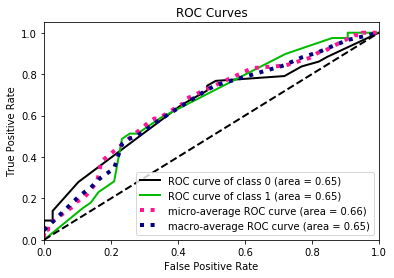

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rfcc = RandomForestClassifier()
rfcc.fit(X_train, y_train)

# predict probabilities
probs = rfcc.predict_proba(X_test)


skplt.metrics.plot_roc(y_test, probs)
plt.show() 

In [146]:
nb = GaussianNB()
val = cross_val_predict(nb, X, y)
print("accuracy_score",metrics.accuracy_score(y, val))
print("roc_auc_score",metrics.roc_auc_score(y, val))
print("confusion_matrix",metrics.confusion_matrix(y, val))
print("classification_report",metrics.classification_report(y, val))
cross_val_score(nb, X, y, cv=K).mean()
nb.fit(X, y)

accuracy_score 0.49877750611246946
roc_auc_score 0.5016021808790473
confusion_matrix [[ 24 182]
 [ 23 180]]
classification_report              precision    recall  f1-score   support

          0       0.51      0.12      0.19       206
          1       0.50      0.89      0.64       203

avg / total       0.50      0.50      0.41       409



GaussianNB(priors=None)

In [167]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
val = cross_val_predict(xgb, X, y)
print("accuracy_score",metrics.accuracy_score(y, val))
print("roc_auc_score",metrics.roc_auc_score(y, val))
print("confusion_matrix",metrics.confusion_matrix(y, val))
print("classification_report",metrics.classification_report(y, val))
xgb.fit(X, y)
cross_val_score(xgb, X, y, cv=K).mean()

/Users/LujFel/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/LujFel/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/LujFel/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy_score 0.628361858190709
roc_auc_score 0.6287722990099956
confusion_matrix [[118  88]
 [ 64 139]]
classification_report              precision    recall  f1-score   support

          0       0.65      0.57      0.61       206
          1       0.61      0.68      0.65       203

avg / total       0.63      0.63      0.63       409



/Users/LujFel/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/LujFel/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/LujFel/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/LujFel/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array 

0.7017765733212888

In [147]:
sv.coef_.shape

(1, 16)

In [148]:
lr_co = lr.coef_.T
lr_co.shape = (16, )
lr_co.shape
dt_co = dt.feature_importances_
rfc_co = rfc.feature_importances_
sv_co = sv.coef_
sv_co.shape = (16, )

coef_df = pd.DataFrame([[log,tree, sv, rfc] for log, tree, sv, rfc in zip(lr_co.tolist(), dt_co.tolist() \
                                                                          , sv_co.tolist(), rfc_co.tolist())], 
                       columns=["logistic_regression", "dtree", "svm", "random_forest"], index=X_test.columns)
#data frame showing the feature importance (metro area) in each model
# looks like SF scores high in all selected models
coef_df

,logistic_regression,dtree,svm,random_forest
Atlanta,0.693660,0.070885,0.25,0.051036
Austin,-0.746179,0.031516,-0.45,0.056728
Boston,0.753281,0.067631,0.25,0.044596
Chicago,0.729901,0.098383,0.55,0.060326
Dallas,0.161848,0.000000,0.00,0.036796
Denver,-0.516889,0.024473,-0.50,0.042770
Houston,-0.405224,0.015852,-0.35,0.046617
Los+Angeles,0.460344,0.061100,0.20,0.064324
Miami,-1.518101,0.157462,-0.50,0.118564
New+York,-0.082565,0.014628,-0.65,0.032929


# LOCATIONS + LEVELS AND CATEGORIES MODELING

In [149]:
# to join the title feature columns to the dummified metro area df
X = pd.concat((X, df[['senior', 'manager', 'analyst', 'scientist', 'engineer']]), axis=1)


In [150]:
X.head(2)

,Atlanta,Austin,Boston,Chicago,Dallas,Denver,Houston,Los+Angeles,Miami,New+York,...,Phoenix,Pittsburgh,Portland,San+Francisco,Seattle,senior,manager,analyst,scientist,engineer
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Trying some of the same models wih dif tuning parameters

In [151]:
#performs better!
lrcv = LogisticRegressionCV(solver='lbfgs', Cs=10)
val = cross_val_predict(lr, X, y)
print("accuracy_score",metrics.accuracy_score(y, val))
print("roc_auc_score",metrics.roc_auc_score(y, val))
print("confusion_matrix",metrics.confusion_matrix(y, val))
print("classification_report",metrics.classification_report(y, val))
lr.fit(X, y)
cross_val_score(lr, X, y, cv=K).mean()

accuracy_score 0.6381418092909535
roc_auc_score 0.6384810368740733
confusion_matrix [[122  84]
 [ 64 139]]
classification_report              precision    recall  f1-score   support

          0       0.66      0.59      0.62       206
          1       0.62      0.68      0.65       203

avg / total       0.64      0.64      0.64       409



0.6844625112917797

In [152]:
sv = SVC(kernel='linear', C=0.05)
val = cross_val_predict(sv, X, y)
print("accuracy_score",metrics.accuracy_score(y, val))
print("roc_auc_score",metrics.roc_auc_score(y, val))
print("confusion_matrix",metrics.confusion_matrix(y, val))
print("classification_report",metrics.classification_report(y, val))
sv.fit(X, y)
cross_val_score(sv, X, y, cv=K).mean()

accuracy_score 0.6381418092909535
roc_auc_score 0.6383375579893824
confusion_matrix [[126  80]
 [ 68 135]]
classification_report              precision    recall  f1-score   support

          0       0.65      0.61      0.63       206
          1       0.63      0.67      0.65       203

avg / total       0.64      0.64      0.64       409



0.6260162601626016

In [153]:
dt = DecisionTreeClassifier()
grid = GridSearchCV(dt, {'max_depth': np.linspace(1, 15)})
val = cross_val_predict(dt, X, y)
print("accuracy_score",metrics.accuracy_score(y, val))
print("roc_auc_score",metrics.roc_auc_score(y, val))
print("confusion_matrix",metrics.confusion_matrix(y, val))
print("classification_report",metrics.classification_report(y, val))
grid.fit(X, y)
cross_val_score(grid, X, y, cv=K).mean()

accuracy_score 0.5990220048899756
roc_auc_score 0.5992156487636903
confusion_matrix [[118  88]
 [ 76 127]]
classification_report              precision    recall  f1-score   support

          0       0.61      0.57      0.59       206
          1       0.59      0.63      0.61       203

avg / total       0.60      0.60      0.60       409



0.633032219211081

In [154]:
lr = LogisticRegression(solver='lbfgs')
val = cross_val_predict(lr, X, y)
print("accuracy_score",metrics.accuracy_score(y, val))
print("roc_auc_score",metrics.roc_auc_score(y, val))
print("confusion_matrix",metrics.confusion_matrix(y, val))
print("classification_report",metrics.classification_report(y, val))
lr.fit(X, y)
cross_val_score(lr, X, y, cv=K).mean()

accuracy_score 0.6381418092909535
roc_auc_score 0.6384810368740733
confusion_matrix [[122  84]
 [ 64 139]]
classification_report              precision    recall  f1-score   support

          0       0.66      0.59      0.62       206
          1       0.62      0.68      0.65       203

avg / total       0.64      0.64      0.64       409



0.6722071665161097

In [155]:
nb = GaussianNB()
val = cross_val_predict(nb, X, y)
print("accuracy_score",metrics.accuracy_score(y, val))
print("roc_auc_score",metrics.roc_auc_score(y, val))
print("confusion_matrix",metrics.confusion_matrix(y, val))
print("classification_report",metrics.classification_report(y, val))
nb.fit(X, y)
cross_val_score(nb, X, y, cv=K).mean()

accuracy_score 0.5599022004889975
roc_auc_score 0.5620665742024965
confusion_matrix [[ 55 151]
 [ 29 174]]
classification_report              precision    recall  f1-score   support

          0       0.65      0.27      0.38       206
          1       0.54      0.86      0.66       203

avg / total       0.60      0.56      0.52       409



0.5818729298404095

In [156]:
rfc = RandomForestClassifier()
val = cross_val_predict(rfc, X, y)
print("accuracy_score",metrics.accuracy_score(y, val))
print("roc_auc_score",metrics.roc_auc_score(y, val))
print("confusion_matrix",metrics.confusion_matrix(y, val))
print("classification_report",metrics.classification_report(y, val))
rfc.fit(X, y)
cross_val_score(rfc, X, y, cv=K).mean()

accuracy_score 0.6259168704156479
roc_auc_score 0.6266320723133578
confusion_matrix [[109  97]
 [ 56 147]]
classification_report              precision    recall  f1-score   support

          0       0.66      0.53      0.59       206
          1       0.60      0.72      0.66       203

avg / total       0.63      0.63      0.62       409



0.6626919602529359

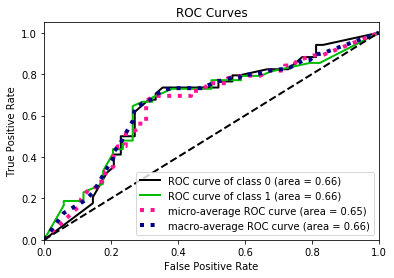

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rfcc = RandomForestClassifier()
rfcc.fit(X_train, y_train)

# predict probabilities
probs = rfcc.predict_proba(X_test)

skplt.metrics.plot_roc(y_test, probs)
plt.show() 

In [165]:
lr_co = lr.coef_.T
lr_co.shape = (21, )
lr_co.shape
rfc_co = rfc.feature_importances_
sv_co = sv.coef_
sv_co.shape = (21, )

coef_df = pd.DataFrame([[log, sv, rfc] for log, sv, rfc in zip(lr_co.tolist(), \
                                                                           sv_co.tolist(), rfc_co.tolist())], 
                       columns=["logistic_regression", "svm", "random_forest"], index=X.columns)
#data frame showing the feature importance (metro area) in each model
# looks like engineer and analyst abs scores are high 
coef_df

,logistic_regression,svm,random_forest
Atlanta,0.861470,0.250000,0.020794
Austin,-0.836287,-0.355000,0.029973
Boston,0.574448,0.200000,0.016567
Chicago,0.609568,0.410648,0.024066
Dallas,0.044895,0.000000,0.034370
Denver,-0.529611,-0.355648,0.024791
Houston,-0.439004,-0.250000,0.024356
Los+Angeles,0.535700,0.148457,0.033610
Miami,-1.456227,-0.350000,0.033517
New+York,0.007886,-0.100000,0.035915


### Conclusion

Indeed job postings website data has been scraped for a list of major cities with search key words (data scientist). The features collected for each posting included the title, location, salary, and company name. more than 17000 observations were collected, however only 400 could be using for analysis because they included yearly salary (our target variable). Each location (metro area) searched were treated as an individual feature, as well as some key words contained in the title such as manager, sr, etc. 

In order to model the behavior of salary in relation to the other feature, many ML classification algorithms were used, such Decision Trees, Random Forest, and Support Vector Machines. However, the simplest one, Logistic Regression, actually performed better overall achieving an accuracy score of 0.70. 

Some limitation to the taken approach including not taking into account more keyword features in the title, though I chose not to to avoid over fitting (over optimizing as in the model scores well on the data available but is not new data). Other limitations in the approach is using only the metro area to predict instead of the actual location (city and state), perhaps some states jobs have higher salaries because of some specific state laws which would be hard to model in interstate cities such as Washington DC (VA and MD), New York City (NY, NJ), and so on. Lastly, the number of observations (400) is really small considering the actual number of job postings on indeed, let alone actual vacancies in real life. In the future, we can scrape more than one job posting platform website or incorporate the hourly rate into the dataset. 